<a href="https://colab.research.google.com/github/raquelcarmo/tropical_cyclones/blob/main/src/code/TC_Vmax_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# insert your desired path to work on
%cd /content/drive/My Drive/ESRIN_PhiLab/Tropical_Cyclones/data
%ls

/content/drive/My Drive/ESRIN_PhiLab/Tropical_Cyclones/data
best_track/                            SAR_swath_images_VV+VH+WS_old/
model_comparisons_between_datasets/    SAR_swath_images_WS+sWSO+cWSO/
model.png                              SAR_swath_images_WS+sWSO+cWSO_old/
parametric_model/                      SAR_swath_images_WS+WS+WS/
SAR_IMAGE_DATASET_EYE_CLASSIFICATION@  SAR_swath_images_WS+WS+WS_old/
SAR_swath_images@                      SAR_swath_masks/
SAR_swath_images_VV+VH+VH/             SAR_swath_nc/
SAR_swath_images_VV+VH+VH_old/         SAR_swath_Vmax/
SAR_swath_images_VV+VH+WS/


In [ ]:
!pip install netcdf4

     |████████████████████████████████| 4.7MB 4.3MB/s 
     |████████████████████████████████| 327kB 34.3MB/s 


In [ ]:
# general imports
import netCDF4
import random
import glob
import os
import sys
sys.stdout.flush()
import pandas as pd
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import imageio
import os.path
import time
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
from scipy.interpolate import interp1d
from google.colab.patches import cv2_imshow
import random
from shapely.geometry import Point
import re
import pickle
import scipy
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import datetime

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import Input
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import resnet50, mobilenet_v2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate, Dense, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, TruePositives, FalsePositives, TrueNegatives, FalseNegatives
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

np.set_printoptions(precision=4)

In [ ]:
def knots_to_m_sec(kts):
  """ Converts knots (kt) to meters/second (m/s) """
  if np.isnan(kts):
    return kts
  else:
    return kts * 0.514444

In [ ]:
# load generic best tracks CSV file
TC_dataset = pd.read_csv("best_track/ibtracs.since1980.list.v04r00.csv", header=0)

# load dataframe connecting .nc filename to TC Name and USA_ATCF_ID
nc_ID = pd.read_csv("SAR_swath_nc/cyclobs_tc_dataframe.csv", header=0)

file_list = glob.glob('SAR_swath_nc/*/*.nc')
files = []
ids = []
cyclob_Vmax_list = []
ws_Vmax_list = []
best_track_Vmax_list = []
tmax_list = []
ws_Vmax_masked_list = []
cnt=0
for single_file in file_list:

  nc_filename = os.path.basename(single_file)
  df = nc_ID[nc_ID.data == nc_filename]
  cyclob_Vmax = df['vmax (m/s)'].values
  id = df.sid.values

  ##############################
  # READ THE NC PRODUCT
  full_info_image = netCDF4.Dataset(single_file, mode='r') 
  tmax_units = datetime.datetime.strptime(full_info_image.measurementDate, '%Y-%m-%dT%H:%M:%SZ')
  tmax = tmax_units.strftime('%Y-%m-%d %H_%M_%S')

  feature_wind = full_info_image.variables["wind_speed"][:]
  feature_wind = feature_wind[0]
  ws_Vmax = np.max(feature_wind)
  #print(ws_Vmax)

  mask = full_info_image.variables["mask_flag"][:]
  feature_wind[mask[0] != 0] = 0
  ws_Vmax_masked = np.max(feature_wind)
  if ws_Vmax != ws_Vmax_masked:
    cnt +=1
  full_info_image.close()
  ##############################

  # get rows in the TC best track that are taken in the same day of the TC
  day = tmax[:10]
  img_info = TC_dataset.loc[TC_dataset.ISO_TIME.str.contains(day)]
  img_info = img_info.loc[img_info.USA_ATCF_ID == id[0].upper()]

  for index, row in img_info.iterrows():
    img_info['ISO_TIME'][index] = datetime.datetime.strptime(img_info['ISO_TIME'][index], '%Y-%m-%d %H:%M:%S')
  img_info['USA_WIND'] = img_info['USA_WIND'].astype(float)
  aux = img_info[['ISO_TIME', 'USA_WIND']]

  df2 = pd.DataFrame([[tmax_units, np.nan]], columns=['ISO_TIME', 'USA_WIND'])
  #print(df2)
  aux = aux.append(df2, ignore_index=True)
  aux = aux.sort_values(by='ISO_TIME')
  #print(aux)

  interp = aux.interpolate()
  #print(interp)
  best_track_Vmax = interp.USA_WIND.loc[interp.ISO_TIME == tmax_units].values
  #print(best_track_Vmax)

  files.append(single_file)
  ids.append(id[0])
  cyclob_Vmax_list.append(cyclob_Vmax[0])
  best_track_Vmax_list.append(knots_to_m_sec(best_track_Vmax[0]))
  ws_Vmax_list.append(ws_Vmax)
  ws_Vmax_masked_list.append(ws_Vmax_masked)
  tmax_list.append(tmax)

data = {"nc": files, "sid": ids, "tmax": tmax_list, "Vmax_ws": ws_Vmax_list, "Vmax_ws_masked": ws_Vmax_masked_list, "Vmax_cyclob": cyclob_Vmax_list, "Vmax_best_track": best_track_Vmax_list}
final_df = pd.DataFrame(data)
print(cnt)
# save relevant information in a csv file that could be retrived with pandas in the future
#final_df.to_csv("SAR_swath_Vmax/Vmax_info_masked.csv", index = False)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,8,9,14,19,20,25,161,162) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0


In [ ]:
dataset = pd.read_csv("SAR_swath_Vmax/Vmax_info_masked.csv")

file_list = glob.glob('SAR_swath_images_VV+VH+WS/*/*.png')

for image in file_list:
  #category = image.split('/')[-2]

  date = os.path.basename(image)[:-4]
  
  df = dataset.loc[dataset.tmax == date]
  idxs = []
  for idx, row in df.iterrows():
    idxs.append(idx)
  #print("idxs:", idxs)

  if len(idxs) > 1:
    idxs_to_drop = idxs[:-1]
    #print("indxs_to_drop:", idxs_to_drop)
    dataset = dataset.drop(idxs_to_drop)
  
#print(dataset)

times = np.array([item.split("/")[-1][:-4] for item in file_list])
df_tmax = dataset.tmax.values

diff = list(list(set(times)-set(df_tmax)) + list(set(df_tmax)-set(times)))
print(diff)

idxs = []
for item in diff:
  df = dataset.loc[dataset.tmax == item]

  for idx, row in df.iterrows():
    idxs.append(idx)

dataset = dataset.drop(idxs)
dataset["category"] = dataset["nc"].str.split('/', expand=True)[1]
dataset.reset_index()
dataset.to_csv("SAR_swath_Vmax/Vmax_info_masked_filtered.csv", index = False)
dataset

['2019-02-08 02_01_08', '2015-08-24 21_16_56', '2015-10-17 09_58_38', '2015-05-09 09_49_45', '2014-10-17 10_27_54', '2016-02-18 05_59_47', '2014-10-04 21_17_43', '2019-12-24 21_30_51']


,nc,sid,tmax,Vmax_ws,Vmax_ws_masked,Vmax_cyclob,Vmax_best_track,category
4,SAR_swath_nc/category1/s1a-iw-owi-cm-20180409t...,sh192018,2018-04-09 17_32_19,80.000000,80.000000,33,32.152750,category1
5,SAR_swath_nc/category1/s1a-ew-owi-cm-20190329t...,sh222019,2019-03-29 14_03_33,54.040001,54.040001,35,NaN,category1
8,SAR_swath_nc/category1/s1a-iw-owi-cm-20170504t...,sh182017,2017-05-04 07_14_33,80.000000,80.000000,42,41.155520,category1
9,SAR_swath_nc/category1/s1a-ew-owi-cm-20190324t...,sh212019,2019-03-24 10_38_56,66.533333,66.533333,40,NaN,category1
10,SAR_swath_nc/category1/s1b-ew-owi-cm-20180930t...,ep202018,2018-09-30 14_03_11,33.080002,33.080002,33,35.239414,category1
...,...,...,...,...,...,...,...,...
395,SAR_swath_nc/category5/s1a-ew-owi-cm-20180914t...,wp262018,2018-09-14 09_51_28,64.760002,64.760002,75,72.536604,category5
396,SAR_swath_nc/category5/s1b-ew-owi-cm-20180911t...,wp262018,2018-09-11 20_48_44,80.000000,80.000000,72,72.536604,category5
397,SAR_swath_nc/category5/s1a-ew-owi-cm-20180831t...,wp252018,2018-08-31 08_29_35,80.000000,80.000000,77,78.967154,category5
398,SAR_swath_nc/category5/s1a-iw-owi-cm-20170907t...,al112017,2017-09-07 10_30_39,79.519997,79.519997,78,74.594380,category5


Epoch 1/50
12/12 [==============================] - 1s 17ms/step - loss: 1.8095 - accuracy: 0.0847 - val_loss: 1.7725 - val_accuracy: 0.2750
Epoch 2/50
12/12 [==============================] - 0s 6ms/step - loss: 1.7711 - accuracy: 0.2773 - val_loss: 1.7402 - val_accuracy: 0.3250
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 1.7404 - accuracy: 0.3129 - val_loss: 1.7080 - val_accuracy: 0.3250
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 1.7248 - accuracy: 0.2525 - val_loss: 1.6732 - val_accuracy: 0.3250
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 1.6754 - accuracy: 0.2744 - val_loss: 1.6369 - val_accuracy: 0.3250
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 1.6536 - accuracy: 0.2780 - val_loss: 1.6025 - val_accuracy: 0.3250
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 1.6262 - accuracy: 0.2718 - val_loss: 1.5710 - val_accuracy: 0.3250
Epoch 8/50
12/12 [=

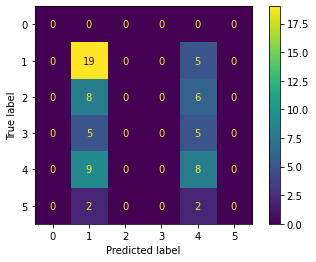

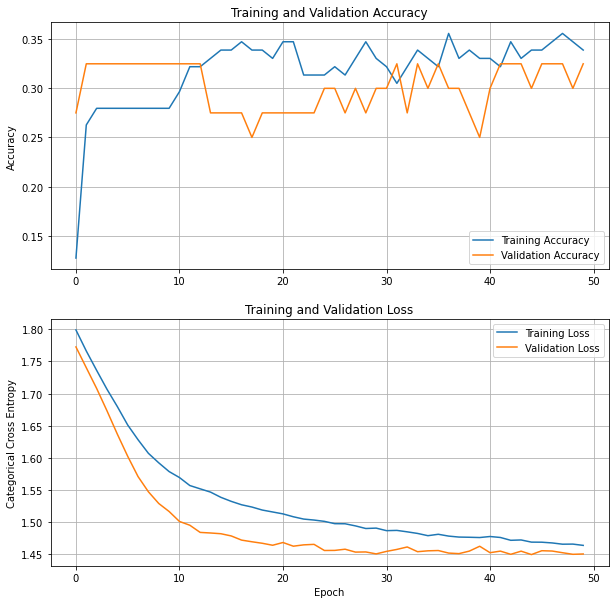

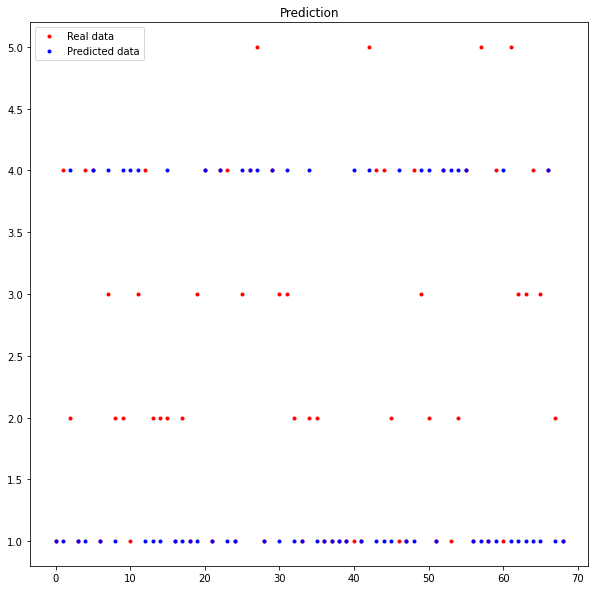

In [ ]:
# Importing the dataset
dataset = pd.read_csv("SAR_swath_Vmax/Vmax_info_masked_filtered.csv")

feature = "Vmax_ws_masked"
X = dataset.loc[:, feature].values
#X = X/X.max()
#print(X)
y = dataset.loc[:, "category"].str.extract('(\d+)').astype(int).values.flatten()

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.08, random_state = 0)
# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# count number of classes
count_classes = y_test.shape[1]

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(32, activation = 'relu', input_dim = 1))

# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the output layer
#model.add(Dense(units = 1))
model.add(Dense(6, activation='softmax'))

# Compiling the ANN
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
#model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
history = model.fit(X_train, y_train,
                    validation_split = 0.25,
                    batch_size = 10,
                    epochs = 50)

y_pred = model.predict(X_test)
#print(y_pred)
predictions = [ np.argmax(t) for t in y_pred ]
#print(predictions)
y_test_non_category = [ np.argmax(t) for t in y_test ]

conf_mat = confusion_matrix(y_test_non_category, predictions, labels = [0,1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [0,1,2,3,4,5])
conf_mat_display = disp.plot()
plt.savefig("SAR_swath_Vmax/regression_results/{}_confusion_matrix.jpg".format(feature))

# PLOT TRAIN/VALIDATION LOSSES
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 10))
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid(True)
ax1.legend(loc='lower right')
ax1.set(ylabel = "Accuracy",
        title = 'Training and Validation Accuracy')

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.grid(True)
ax2.legend(loc='upper right')
ax2.set(xlabel = 'Epoch', 
      ylabel = 'Categorical Cross Entropy',
      title = 'Training and Validation Loss')
plt.show()
fig.savefig("SAR_swath_Vmax/regression_results/{}_learning_curves.jpg".format(feature))

# PLOT PREDICTIONS vs LABELS
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(y_test_non_category, '.', color = 'red', label = 'Real data')
ax.plot(predictions, '.', color = 'blue', label = 'Predicted data')
ax.set(title = 'Prediction')
ax.legend()
plt.show()

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(1,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])


model = Sequential()
model.add(Dense(10, activation='relu', input_dim=1))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


<class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
